In [1]:
import os
import pandas as pd
import numpy as np
import imageio
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from Constants import *
import outputs
%matplotlib inline

In [2]:
image_list_dir = os.listdir(image_dir)
mask_list_dir = os.listdir(mask_dir)
image_list = [image_dir + i for i in image_list_dir]
mask_list = [mask_dir + i for i in mask_list_dir]
print(image_list,'\n',mask_list)

['../data/image/000026.png', '../data/image/000027.png', '../data/image/000028.png', '../data/image/000029.png', '../data/image/000032.png', '../data/image/000033.png', '../data/image/000034.png', '../data/image/000043.png', '../data/image/000044.png', '../data/image/000045.png', '../data/image/000073.png', '../data/image/000084.png', '../data/image/000085.png', '../data/image/000156.png', '../data/image/000688.png', '../data/image/000689.png', '../data/image/000690.png', '../data/image/000691.png', '../data/image/000693.png', '../data/image/000694.png', '../data/image/000695.png', '../data/image/000728.png', '../data/image/001887.png', '../data/image/001888.png', '../data/image/001889.png', '../data/image/001890.png', '../data/image/001891.png', '../data/image/001892.png', '../data/image/001893.png', '../data/image/001894.png', '../data/image/001896.png', '../data/image/001898.png', '../data/image/001902.png', '../data/image/001903.png', '../data/image/001904.png', '../data/image/0019

Text(0.5, 1.0, 'Segmented image')

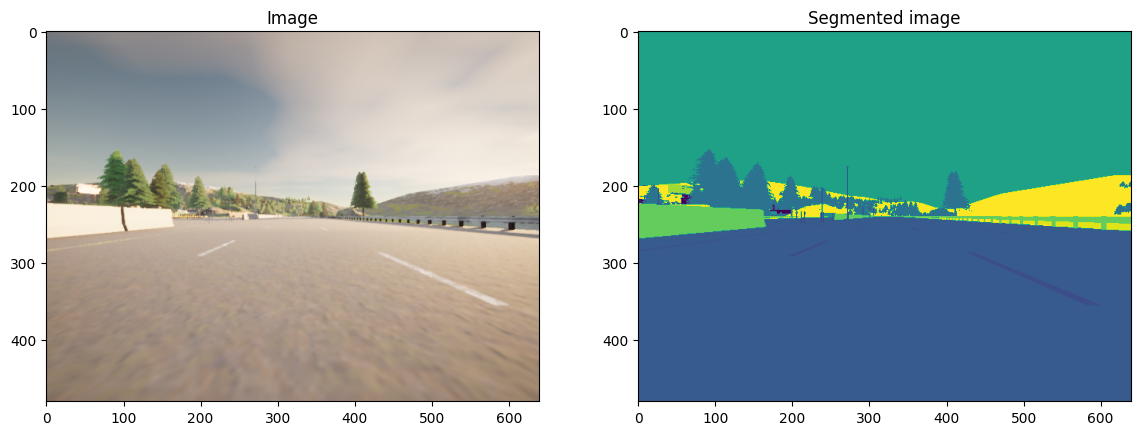

In [3]:
NUM_SAMPLES = 2
image = imageio.v2.imread(image_list[NUM_SAMPLES])
mask = imageio.v2.imread(mask_list[NUM_SAMPLES])

figure, array = plt.subplots(1, 2, figsize = (14, 10))
array[0].imshow(image)
array[0].set_title("Image")
array[1].imshow(mask[:, :, 0])
array[1].set_title("Segmented image")


In [4]:
image_dataset = tf.data.Dataset.list_files(image_list, shuffle = False)
mask_dataset = tf.data.Dataset.list_files(mask_list, shuffle = False)

In [5]:
image_files = tf.constant(image_list)
mask_files = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_files, mask_files))

In [6]:
for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'../data/image/000026.png', shape=(), dtype=string)
tf.Tensor(b'../data/mask/000026.png', shape=(), dtype=string)


In [7]:
def preprocessing_path(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels = 3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels = 3)
    mask = tf.math.reduce_max(mask, axis =- 1, keepdims = True)
    
    return image, mask


def image_preprocessing(image, mask):
    image = tf.image.resize(image, (96, 128), method = 'nearest')
    mask = tf.image.resize(mask, (96, 128), method = 'nearest')
    #image = image / 255.
    
    return image, mask

image_dataset = dataset.map(preprocessing_path)
processed_images = image_dataset.map(image_preprocessing)

In [8]:
# Unet Model

def conv_block(inputs = None, NUM_FILTERS = 32, dropout_prob = 0, max_pooling2D = True):
    
    conv = layers.Conv2D(NUM_FILTERS, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv = layers.Conv2D(NUM_FILTERS, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    
    if dropout_prob > 0:
        conv = layers.Dropout(dropout_prob)(conv)
        
    if max_pooling2D:
        next_layer = layers.MaxPooling2D(pool_size = (2, 2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [9]:
INPUT_SHAPE = (96, 128, 3)
inputs = layers.Input(INPUT_SHAPE)

conv_block1 = conv_block(inputs, NUM_FILTERS * 1)
model_1 = keras.Model(inputs = inputs, outputs = conv_block1)

output_1 = [['InputLayer', [(None, 96, 128, 3)], 0],
           ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
           ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
           ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]]


conv_block1 = conv_block(inputs, NUM_FILTERS * 32, dropout_prob = 0.1, max_pooling2D = True)
model_2 = keras.Model(inputs = inputs, outputs = conv_block1)
output_2 = [['InputLayer', [(None, 96, 128, 3)], 0],
           ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
           ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
           ['Dropout', (None, 96, 128, 1024), 0, 0.1],
           ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]]

In [10]:
def upsampling_block(expansive_input, contractive_input, NUM_FILTERS):
    
    upsample = layers.Conv2DTranspose(NUM_FILTERS, 3, strides = 2, padding = 'same')(expansive_input)
    merge = layers.concatenate([upsample, contractive_input], axis = 3)
    
    conv = layers.Conv2D(NUM_FILTERS, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge)
    conv = layers.Conv2D(NUM_FILTERS, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv)
    
    return conv

In [11]:
INPUT_SHAPE_1 = (12, 16, 256)
INPUT_SHAPE_2 = (24, 32, 128)

expansive_inputs = layers.Input(INPUT_SHAPE_1)
contractive_inputs = layers.Input(INPUT_SHAPE_2)

conv_block1 = upsampling_block(expansive_inputs, contractive_inputs, NUM_FILTERS * 1)
model_1 = keras.Model(inputs = [expansive_inputs, contractive_inputs], outputs = conv_block1)

output_1 = [['InputLayer', [(None, 12, 16, 256)], 0],
           ['Conv2DTranspose', (None, 24, 32, 32), 73760],
           ['InputLayer', (None, 24, 32, 128), 0],
           ['Concatenate', (None, 24, 32, 160), 0],
           ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
           ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']]

In [12]:
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == layers.Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == layers.MaxPooling2D):
            descriptors.append(layer.pool_size)
        if (type(layer) == layers.Dropout):
            descriptors.append(layer.rate)
        result.append(descriptors)
    return result

In [13]:
def Unet_model(input_size = (96, 128, 3), NUM_FILTERS = 32, NUM_CLASSES = 23):
    
    # Encoding block
    inputs = layers.Input(input_size)
    conv_block1 = conv_block(inputs, NUM_FILTERS)
    conv_block2 = conv_block(conv_block1[0], NUM_FILTERS * 2)
    conv_block3 = conv_block(conv_block2[0], NUM_FILTERS * 4)
    conv_block4 = conv_block(conv_block3[0], NUM_FILTERS * 8, dropout_prob = 0.3)
    conv_block5 = conv_block(conv_block4[0], NUM_FILTERS * 16, dropout_prob = 0.3, max_pooling2D = False)
    
    # Decoding block
    upsampling_block1 = upsampling_block(conv_block5[0], conv_block4[1], NUM_FILTERS * 8)
    upsampling_block2 = upsampling_block(upsampling_block1, conv_block3[1], NUM_FILTERS * 4)
    upsampling_block3 = upsampling_block(upsampling_block2, conv_block2[1], NUM_FILTERS * 2)
    upsampling_block4 = upsampling_block(upsampling_block3, conv_block1[1], NUM_FILTERS)
    
    conv_block6 = layers.Conv2D(NUM_FILTERS, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(upsampling_block4)
    conv_block7 = layers.Conv2D(NUM_CLASSES, 1, padding = 'same')(conv_block6)
    
    model = keras.Model(inputs = inputs, outputs = conv_block7)
    
    return model

In [14]:
unet_model = Unet_model((IMAGE_HEIGHT, IMAGE_WIDTH, NUM_CHANNELS))
unet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 96, 128, 32)          896       ['input_4[0][0]']             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d_6[0][0]']            
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 48, 64, 32)           0         ['conv2d_7[0][0]']            
 g2D)                                                                                       

In [15]:
unet_model.compile(optimizer = 'adam', 
                   loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                   metrics = ['accuracy'])

In [16]:
def display_image(display_list):
    
    plt.figure(figsize = (12, 12))
    title = ["Input Image", "True Mask", "Predicted Mask"]
    
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

(480, 640, 1)


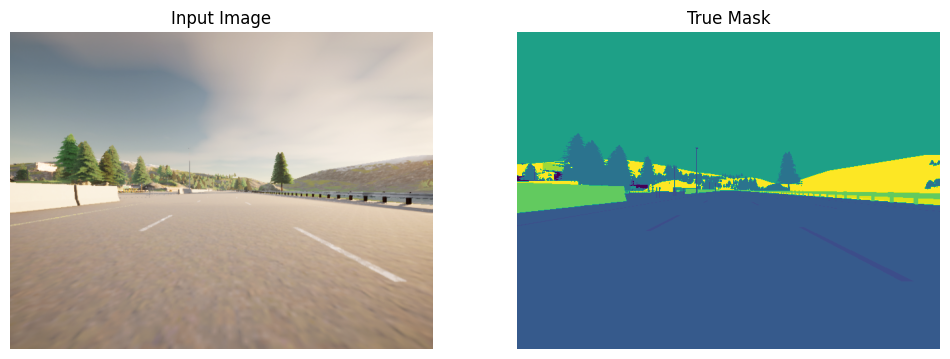

In [17]:
# display sample image, its processed version and their masks

for image, mask in image_dataset.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display_image([sample_image, sample_mask])

(96, 128, 1)


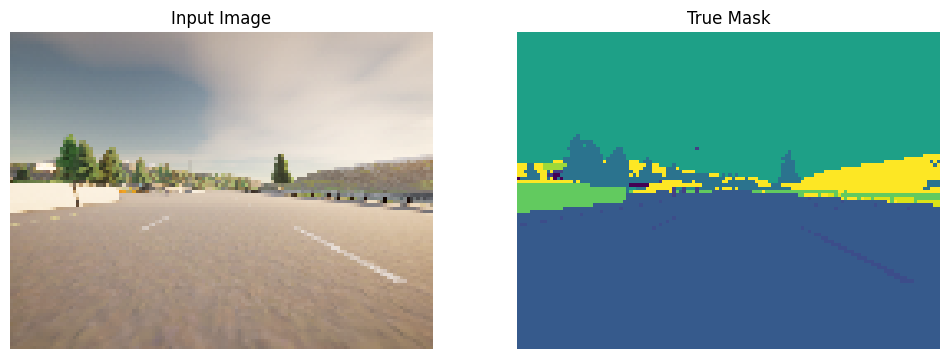

In [18]:
for image, mask in processed_images.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display_image([sample_image, sample_mask])

In [19]:
processed_images.batch(BATCH_SIZE)
train_set = processed_images.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [20]:
history = unet_model.fit(train_set,
                         epochs = EPOCHS)

Epoch 1/20
34/34 [==============================] - 296s 8s/step - loss: 1.7087 - accuracy: 0.5095
Epoch 2/20
34/34 [==============================] - 242s 7s/step - loss: 0.6687 - accuracy: 0.8184
Epoch 3/20
34/34 [==============================] - 252s 7s/step - loss: 0.5053 - accuracy: 0.8542
Epoch 4/20
34/34 [==============================] - 241s 7s/step - loss: 0.4132 - accuracy: 0.8776
Epoch 5/20
34/34 [==============================] - 239s 7s/step - loss: 0.3602 - accuracy: 0.8904
Epoch 6/20
34/34 [==============================] - 240s 7s/step - loss: 0.3247 - accuracy: 0.9016
Epoch 7/20
34/34 [==============================] - 240s 7s/step - loss: 0.3009 - accuracy: 0.9080
Epoch 8/20
34/34 [==============================] - 239s 7s/step - loss: 0.2610 - accuracy: 0.9211
Epoch 9/20
34/34 [==============================] - 273s 8s/step - loss: 0.2285 - accuracy: 0.9315
Epoch 10/20
34/34 [==============================] - 240s 7s/step - loss: 0.2166 - accuracy: 0.9355
Epoch 11/

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


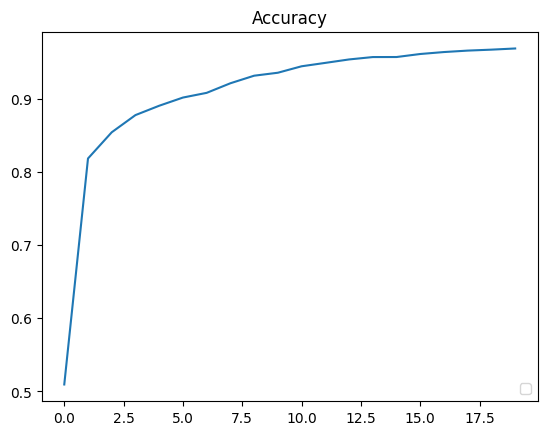

In [21]:
plt.plot(history.history['accuracy'])
plt.title("Accuracy")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


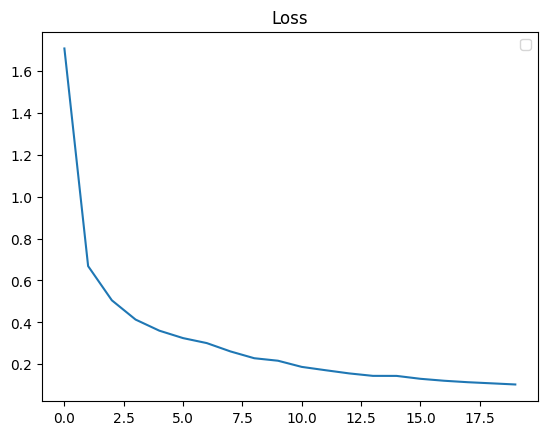

In [25]:
plt.plot(history.history['loss'])
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()

In [22]:
def make_mask(predicted_mask):
    predicted_mask = tf.argmax(predicted_mask, axis =- 1)
    predicted_mask = predicted_mask[..., tf.newaxis]
    
    return predicted_mask[0]

In [33]:
def display_prediction(dataset = None, num = 1):
    
    if dataset:
        for image, mask in dataset.take(num):
            predicted_mask = unet_model.predict(image)
            display_image([image[0], mask[0], make_mask(predicted_mask)])
    else:
        display_image([sample_image,
                 sample_mask,
                 make_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 2s 2s/step


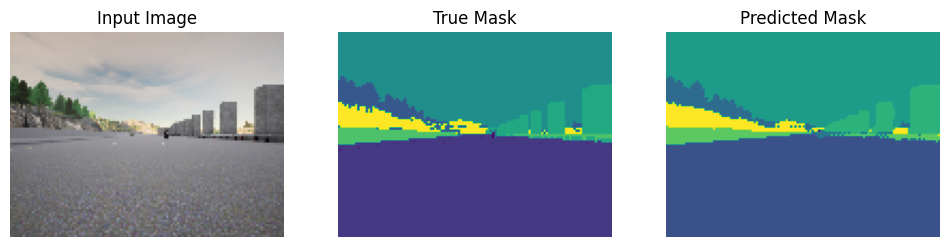

1/1 [==============================] - 2s 2s/step


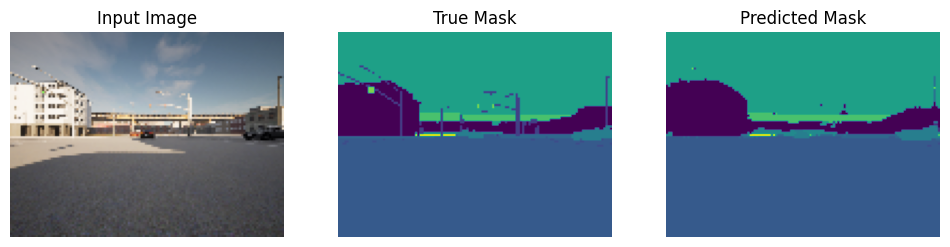

1/1 [==============================] - 3s 3s/step


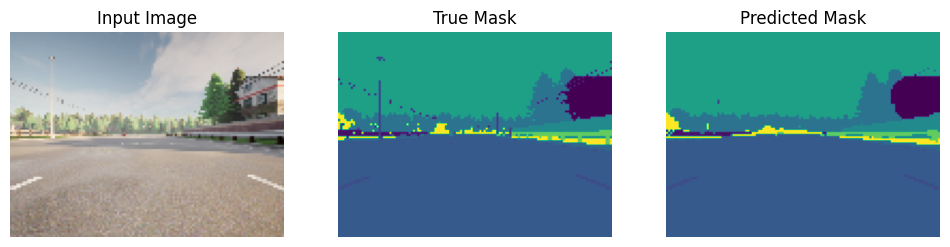

1/1 [==============================] - 2s 2s/step


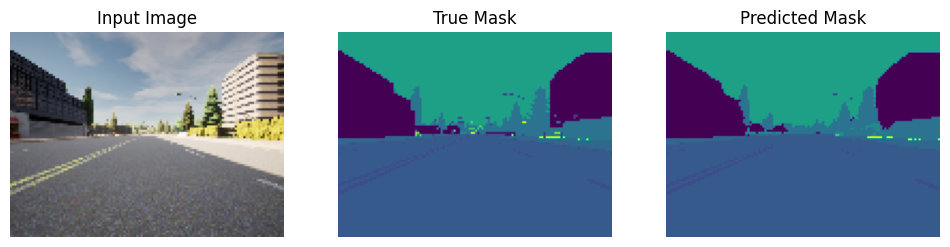

1/1 [==============================] - 2s 2s/step


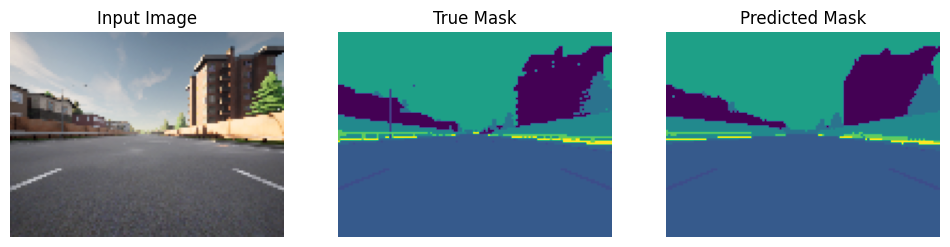

1/1 [==============================] - 2s 2s/step


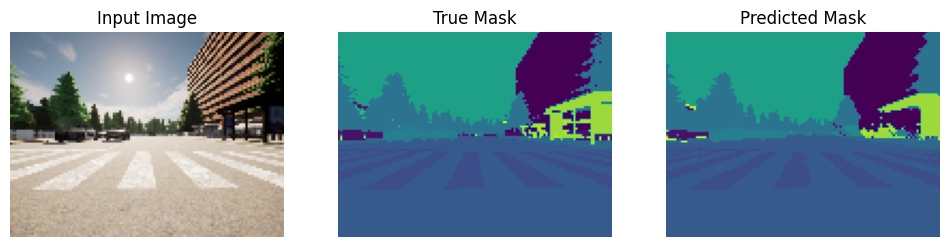

1/1 [==============================] - 2s 2s/step


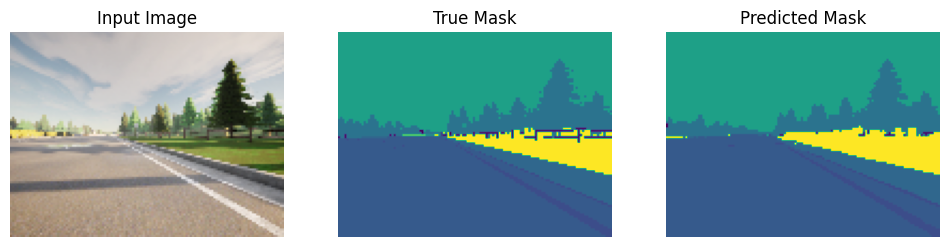

1/1 [==============================] - 3s 3s/step


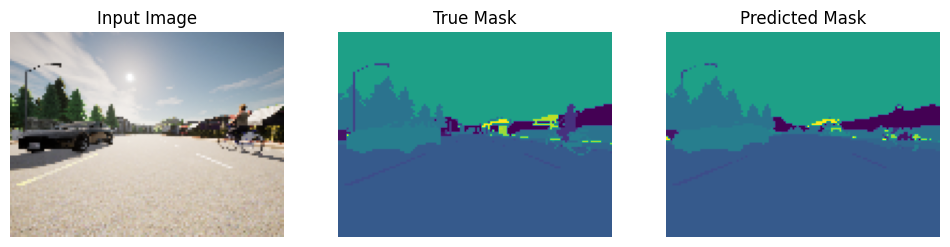

1/1 [==============================] - 2s 2s/step


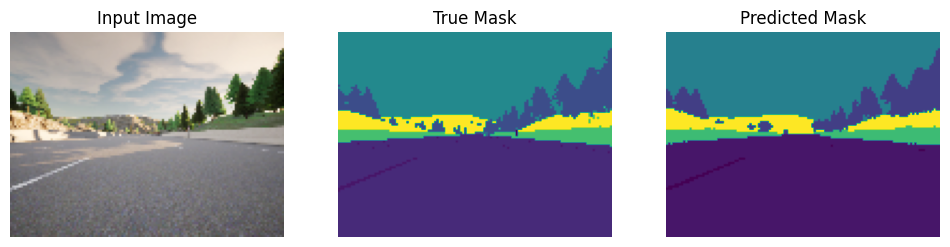

1/1 [==============================] - 2s 2s/step


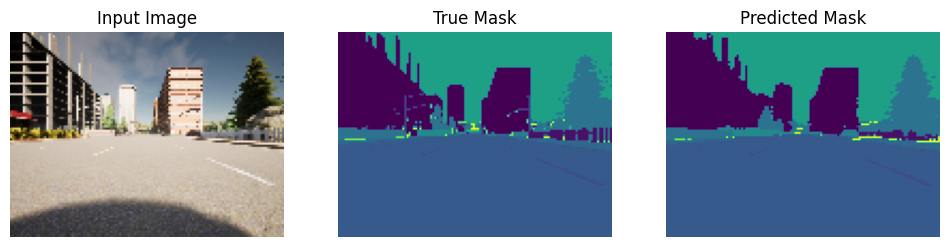

In [35]:
display_prediction(train_set, 10)

In [37]:
unet_model.save("../segmentation_1/")

INFO:tensorflow:Assets written to: ../segmentation/assets


INFO:tensorflow:Assets written to: ../segmentation/assets


In [39]:
# To load
#unet_model = tf.keras.models.load_model("../segmentation_1")